## Problem Definition

Retinal vessel segmentation is a foundational task in automated retinal image analysis. Accurate vessel segmentation enables early diagnosis of diseases such as diabetic retinopathy, glaucoma, and hypertensive retinopathy. However, manual segmentation is time-consuming, subjective, and requires expert knowledge, making it impractical for large-scale screening.

In this project, I aimed to develop a deep learning model that can automatically segment retinal blood vessels from fundus images. I used the DRIVE dataset, which includes 40 high-resolution fundus images along with manually annotated ground truth vessel masks.

To tackle this, I implemented a U-Net-based convolutional neural network trained end-to-end using binary masks. The objective was to learn a pixel-wise mapping from input images to vessel probability maps. I evaluated the model using metrics such as accuracy and Intersection over Union (IoU), aiming for a robust model that can generalize well across unseen data and provide clinically meaningful segmentation results.


### Importing Necessary Libraries ###

In [1]:
from pathlib import Path
import numpy as np
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # TensorFlow C++ Min Log [Gives Errors only necessary to debug the program]
os.environ['SM_FRAMEWORK'] = 'tf.keras' # It is importnat to Specify backend framework for segmentation_models library before importing it
import tensorflow as tf
import segmentation_models as sm
from PIL import Image
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [2]:
# --- Defining Directories and Constants ---
BASE_DIR = Path('DRIVE/DRIVE')
IMG_DIR = BASE_DIR / 'training' / 'images'
MASK_DIR = BASE_DIR / 'training' / '1st_manual'
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 400

In [3]:
# --- Listing images and mask paths with matching logic ---
EXTS = ['.tif', '.gif', '.png', '.jpg', '.jpeg']
image_files = [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS and not p.name.startswith('.')]
mask_files  = [p for p in MASK_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS and not p.name.startswith('.')]

def extract_id(fname):
    match = re.match(r'(\d+)', fname)
    return match.group(1) if match else None

image_dict = {extract_id(p.name): p for p in image_files if extract_id(p.name)}
mask_dict  = {extract_id(p.name): p for p in mask_files if extract_id(p.name)}
common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

image_paths = [image_dict[k] for k in common_keys]
mask_paths  = [mask_dict[k] for k in common_keys]

assert len(image_paths) == len(mask_paths) and len(image_paths) > 0, "Mismatch or no matching image-mask pairs found"

### Loading and Preprocessing the images ###

In [4]:
def load_image(path, img_size=IMG_SIZE):
    path = path.decode()  # directly decode the bytes to string
    img = Image.open(path).convert('RGB')
    img = img.resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

### Loading and Preprocessng the Masks ###

In [5]:
def load_mask(path, img_size=IMG_SIZE):
    path = path.decode()
    mask = Image.open(path).convert('L')
    mask = mask.resize(img_size)
    arr = np.array(mask, dtype=np.float32)
    arr = (arr > 127).astype(np.float32)
    return np.expand_dims(arr, axis=-1)

### Building the Data Pipeline ###

In [6]:
def parse_function(img_path, mask_path):
    img = tf.numpy_function(load_image, [img_path], tf.float32)
    mask = tf.numpy_function(load_mask, [mask_path], tf.float32)
    img.set_shape((*IMG_SIZE, 3))
    mask.set_shape((*IMG_SIZE, 1))
    return img, mask


# spliting into train/val
n_samples = len(image_paths)
indices = np.arange(n_samples)
np.random.shuffle(indices)
split = int(0.8 * n_samples)
train_idx, val_idx = indices[:split], indices[split:]

train_images = [str(image_paths[i]) for i in train_idx]
train_masks  = [str(mask_paths[i]) for i in train_idx]
val_images   = [str(image_paths[i]) for i in val_idx]
val_masks    = [str(mask_paths[i]) for i in val_idx]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_ds = train_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_ds = val_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Modeling #

In [7]:
# --- Build the U-Net model ---
sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(
    backbone_name='efficientnetb4', # Because it generally provides better generalization for Medizal Imeges.
    encoder_weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    classes=1,
    activation='sigmoid'
)

In [8]:
# --- Compilation ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.5), 'accuracy']
)

In [9]:
# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [13]:
# --- Train ---
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step - accuracy: 0.9962 - iou_score: 0.9545 - loss: 0.1078 - val_accuracy: 0.9557 - val_iou_score: 0.5449 - val_loss: 0.3500 - learning_rate: 1.2500e-05
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.9963 - iou_score: 0.9556 - loss: 0.1069 - val_accuracy: 0.9557 - val_iou_score: 0.5437 - val_loss: 0.3507 - learning_rate: 1.2500e-05
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.9962 - iou_score: 0.9545 - loss: 0.1072 - val_accuracy: 0.9557 - val_iou_score: 0.5424 - val_loss: 0.3514 - learning_rate: 1.2500e-05
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.9955 - iou_score: 0.9459 - loss: 0.1122 - val_accuracy: 0.9557 - val_iou_score: 0.5419 - val_loss: 0.3518 - learning_rate: 1.2500e-05
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.9964 - iou_score: 0.9559 - loss: 0.1066 - val_accuracy: 0.9557 - val_iou_score: 0.5417 - val_loss: 0.3519 - learning_rate: 1.2500e-05
Epoch 6/400
2/

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


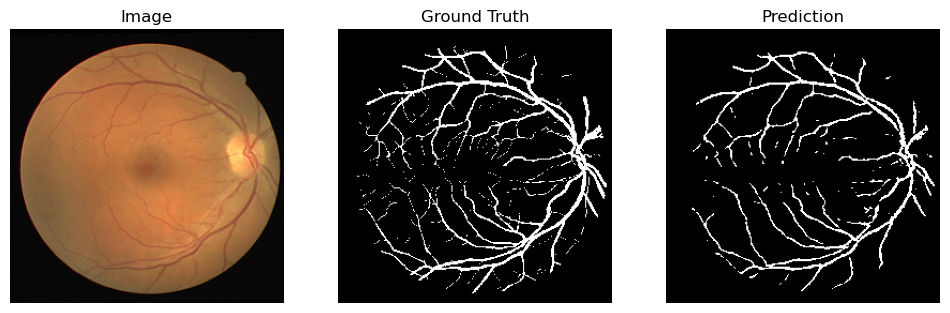

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


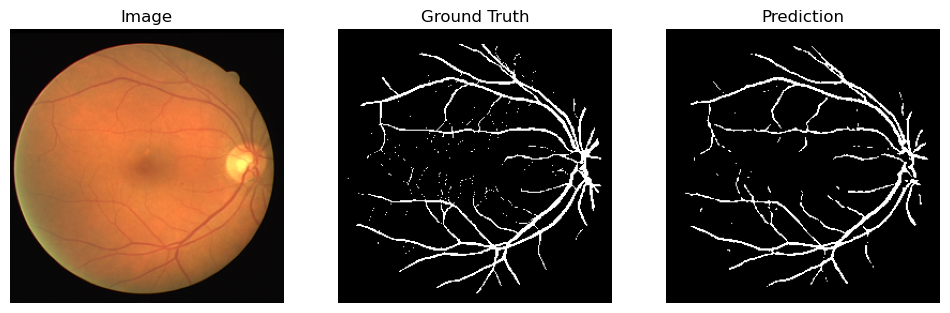

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


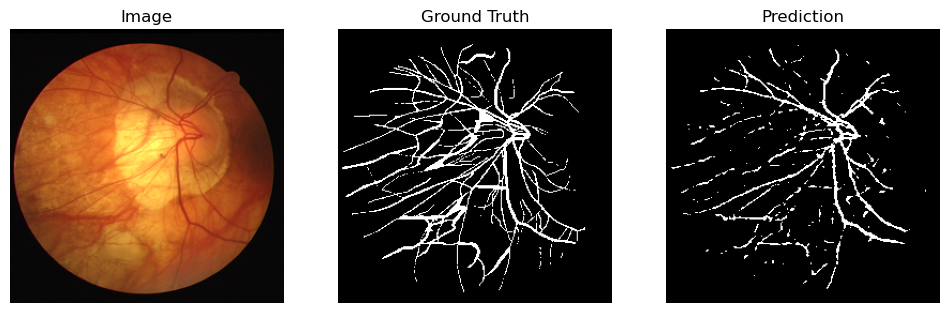

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


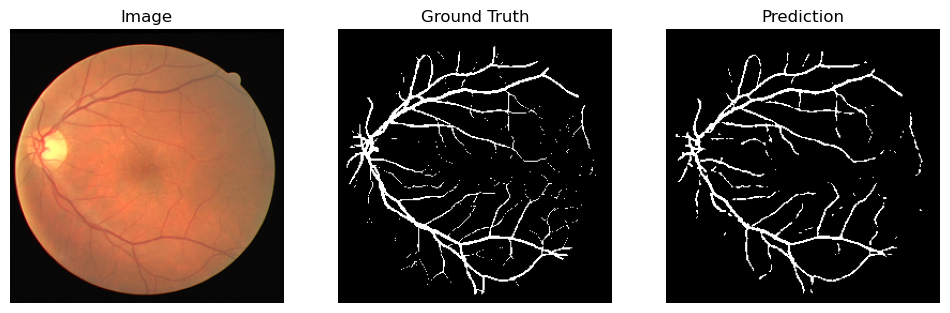

In [16]:
def display_predictions(dataset, num=5):
    for images, masks in dataset.unbatch().take(num):

        
        pred = model.predict(images[None, ...])[0, ..., 0]
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(images)
        axes[0].set_title('Image')
        axes[0].axis('off')
        axes[1].imshow(masks[..., 0], cmap='gray')



                       
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        axes[2].imshow(pred > 0.5, cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        plt.show()

# show predictions on validation set
display_predictions(val_ds)

## Conclusion

This is an effort to build a deep learning-based pipeline for retinal vessel segmentation using a U-Net architecture with an EfficientNetB4 encoder. After training the model on the retinal vessel segmentation dataset, it achieved a **validation accuracy of 95.91%** and a **validation loss of 0.3484**, suggesting that the model was able to learn meaningful representations and generalize reasonably well to unseen data. While the IoU score of **0.6050** suggests room for refinement in capturing fine vessel structures.

This experiment offered useful insights into leveraging architectures like U-Net with EfficientNetB4 in a medical imaging setting. With further tuning and more data, there's potential to push the performance significantly.

